In [5]:
import torchvision.transforms.functional as TF
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ",device)

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange
    
print("Import Completed")

import sys
sys.path.append("..")
from latexify import latexify, format_axes



Device:  cpu
Import Completed


In [6]:
# Set the random seed for reproducibility
torch.manual_seed(42)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")

torch.Size([3, 600, 900])


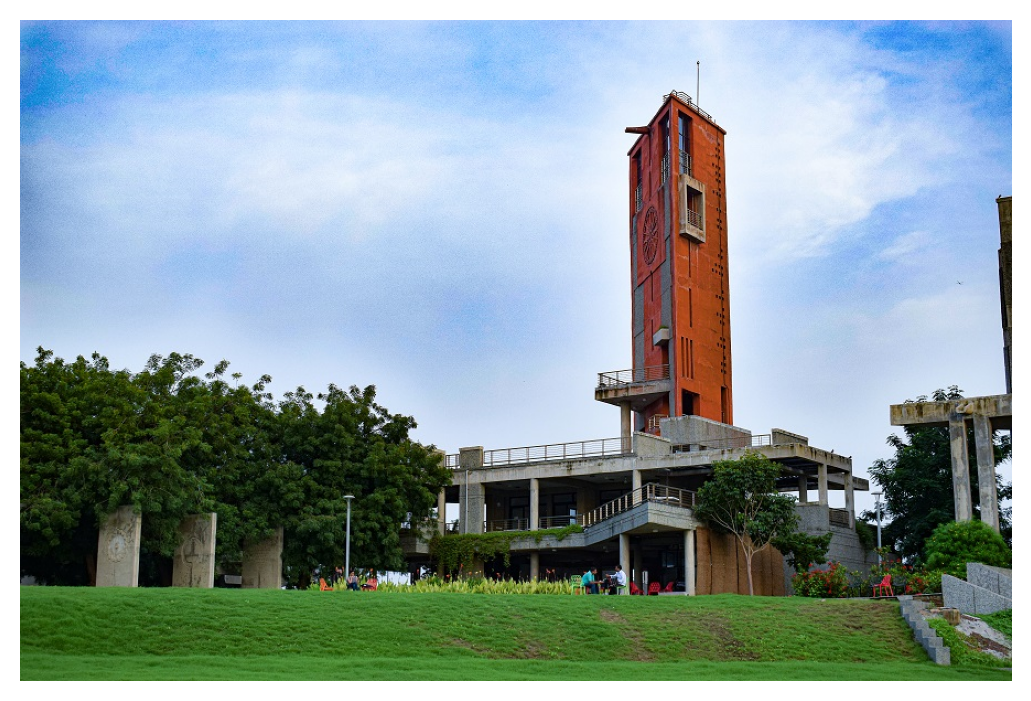

In [7]:
# Read in a image from torchvision
img = torchvision.io.read_image("../assets/images/iitgn.jpg")
print(img.shape)
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())
plt.axis('off')
plt.show()

In [8]:
from sklearn import preprocessing
# scaling the image tensor
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [9]:
# apply the fitted scalar to the reshaped image  , and then reshape back to the original dimensions
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)
img_scaled = torch.tensor(img_scaled)

(3, 600, 900)


In [10]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.5412, 0.5333, 0.4863,  ..., 0.5451, 0.5608, 0.5412],
         [0.5059, 0.5373, 0.5059,  ..., 0.5647, 0.5451, 0.5451],
         [0.5412, 0.5333, 0.5098,  ..., 0.5647, 0.5216, 0.5373],
         ...,
         [0.2627, 0.2941, 0.2549,  ..., 0.2314, 0.2157, 0.1843],
         [0.1647, 0.1647, 0.1882,  ..., 0.2314, 0.2196, 0.2078],
         [0.2039, 0.2275, 0.2588,  ..., 0.2157, 0.2039, 0.2157]],

        [[0.6902, 0.6902, 0.6667,  ..., 0.6667, 0.6824, 0.6627],
         [0.6549, 0.6941, 0.6667,  ..., 0.6863, 0.6667, 0.6667],
         [0.6784, 0.6706, 0.6471,  ..., 0.6863, 0.6431, 0.6588],
         ...,
         [0.4667, 0.4980, 0.4588,  ..., 0.4157, 0.4000, 0.3686],
         [0.3647, 0.3647, 0.3882,  ..., 0.4157, 0.4039, 0.3922],
         [0.4039, 0.4275, 0.4588,  ..., 0.4000, 0.3882, 0.4000]],

        [[0.9333, 0.9294, 0.9020,  ..., 0.9294, 0.9451, 0.9255],
         [0.8980, 0.9333, 0.9098,  ..., 0.9490, 0.9294, 0.9294],
         [0.9294, 0.9216, 0.9059,  ..., 0.9412, 0.8980, 0.

In [29]:
# Functional Crop
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 150, 300, 400, 400)
print(crop.shape)


# # Load original high-resolution image (assuming it's 400x400)
original_img = crop  # Assuming crop is your 400x400 image
low_res_img = TF.resize(original_img, [200, 200])  # Resize to 200x200
print(low_res_img.shape)

# # Center crop
# center_crop = torchvision.transforms.CenterCrop(300)  # Crop to a 300x300 square
# crop = center_crop(img_scaled.cpu())
# print(crop.shape)


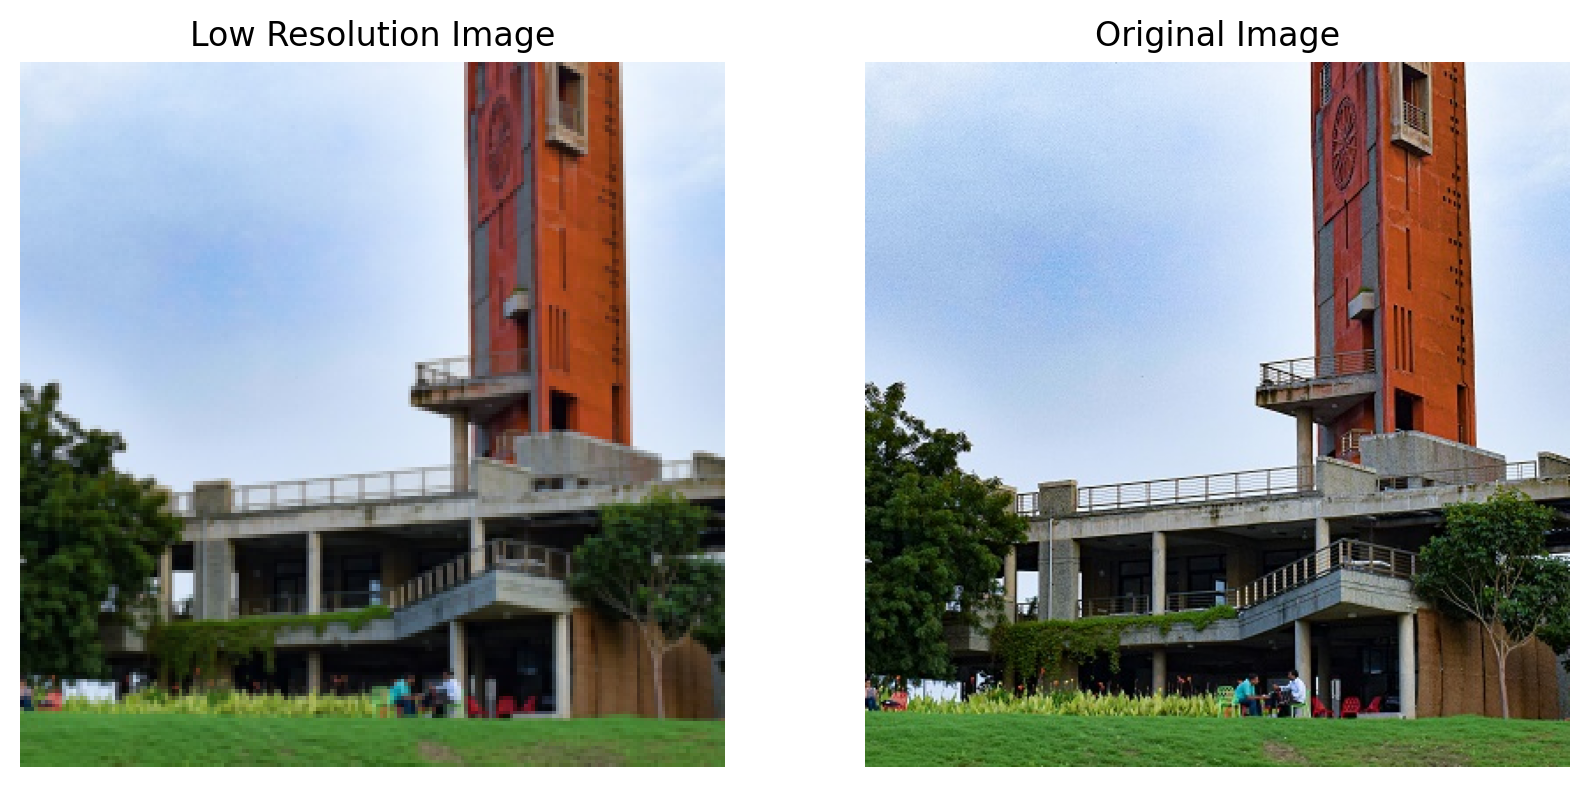

In [30]:
# compare both the images low res img and original image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(rearrange(low_res_img, 'c h w -> h w c').cpu().numpy())
ax[0].set_title("Low Resolution Image")
ax[0].axis('off')

ax[1].imshow(rearrange(original_img, 'c h w -> h w c').cpu().numpy())
ax[1].set_title("Original Image")
ax[1].axis('off')
plt.show()

In [31]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape
    print("Number of channels:", num_channels, "\nHeight:", height, "\nWidth:", width)
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    print("-"*50)
    
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)
    print("X shape:", X.shape)
    
    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    print("Y shape:", Y.shape)

    return X, Y

In [32]:
import torch
import sklearn.preprocessing as preprocessing


low_res_X, low_res_Y = create_coordinate_map(low_res_img)
high_res_X, _ = create_coordinate_map(original_img)  # Only need the coordinates for high-res

print(low_res_X.shape, low_res_Y.shape)
print(low_res_X , low_res_Y)
print(high_res_X.shape)
print(high_res_X)

# Scale low-res coordinates
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(low_res_X.cpu())
low_res_X_scaled = scaler_X.transform(low_res_X.cpu())
high_res_X_scaled = scaler_X.transform(high_res_X.cpu())  # Scale high-res coordinates

low_res_X_scaled = torch.tensor(low_res_X_scaled).float().to(device)
high_res_X_scaled = torch.tensor(high_res_X_scaled).float().to(device)


Number of channels: 3 
Height: 200 
Width: 200
--------------------------------------------------
X shape: torch.Size([40000, 2])
Y shape: torch.Size([40000, 3])
Number of channels: 3 
Height: 400 
Width: 400
--------------------------------------------------
X shape: torch.Size([160000, 2])
Y shape: torch.Size([160000, 3])


In [33]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [34]:
X_rff_low_res = create_rff_features(low_res_X_scaled, num_features=25000, sigma=0.008)
print("X_rff_low_res shape:", X_rff_low_res.shape)
print(X_rff_low_res)

X_rff_low_res shape: torch.Size([40000, 10000])
tensor([[-0.0063,  0.0033, -0.0128,  ..., -0.0115, -0.0042, -0.0136],
        [-0.0040,  0.0051, -0.0131,  ..., -0.0133, -0.0128,  0.0084],
        [-0.0015,  0.0068, -0.0052,  ..., -0.0141,  0.0075,  0.0002],
        ...,
        [-0.0071,  0.0107, -0.0045,  ..., -0.0097,  0.0062, -0.0141],
        [-0.0091,  0.0093,  0.0067,  ..., -0.0066,  0.0118,  0.0104],
        [-0.0109,  0.0078,  0.0137,  ..., -0.0031, -0.0093, -0.0024]])


In [35]:
# linear Regression - neural  network with one input and output layer - no hidden layers
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        # Define a linear transformation
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

In [36]:

# update the train function to exit if loss is not decreasing

def train(net, lr, X, Y, epochs, verbose=True):

    losses = []
    count =0
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(1,epochs+1):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

        if epoch > 1 and losses[-2] < losses[-1]:
            count+=1
            if count>3:
                print("Loss is not decreasing. Exiting...")
                break
    return loss.item(),losses

In [37]:
# Initialize and train the model
model = LinearModel(X_rff_low_res.shape[1], 3)  # 3 for RGB channels
model.to(device)
print(model)

# Train the model with the low-res coordinates and pixel values
train_loss,training_losses = train(model, lr=0.005, X=X_rff_low_res, Y=low_res_Y, epochs=5000)
print(f"Final training loss: {train_loss:.6f}")
# train_loss,training_losses = train(net, 0.01, dog_X_scaled, dog_Y, 1000)

# Now use the learned model to predict for high-resolution coordinates
X_rff_high_res = create_rff_features(high_res_X_scaled, num_features=25000, sigma=0.008)
print("X_rff_high_res shape:", X_rff_high_res.shape)
print(X_rff_high_res)


LinearModel(
  (linear): Linear(in_features=10000, out_features=3, bias=True)
)
Epoch 100 loss: 0.105218
Epoch 200 loss: 0.079284
Epoch 300 loss: 0.072253
Epoch 400 loss: 0.066873
Epoch 500 loss: 0.062405
Epoch 600 loss: 0.058591
Epoch 700 loss: 0.055278
Epoch 800 loss: 0.052369
Epoch 900 loss: 0.049789
Epoch 1000 loss: 0.047484
Epoch 1100 loss: 0.045409
Epoch 1200 loss: 0.043529
Epoch 1300 loss: 0.041816
Epoch 1400 loss: 0.040246
Epoch 1500 loss: 0.038800
Epoch 1600 loss: 0.037463
Epoch 1700 loss: 0.036220
Epoch 1800 loss: 0.035062
Epoch 1900 loss: 0.033979
Epoch 2000 loss: 0.032962
Final training loss: 0.032962
X_rff_high_res shape: torch.Size([160000, 10000])
tensor([[-9.5703e-03,  1.3803e-02, -1.3479e-02,  ..., -1.2836e-02,
          1.4137e-02, -1.3047e-02],
        [ 8.4778e-03,  1.3298e-02, -7.1230e-03,  ..., -1.3197e-05,
          1.3789e-02,  1.1161e-02],
        [ 1.2684e-02,  1.2575e-02,  2.9155e-03,  ...,  1.2825e-02,
          1.2903e-02,  2.0837e-03],
        ...,
       

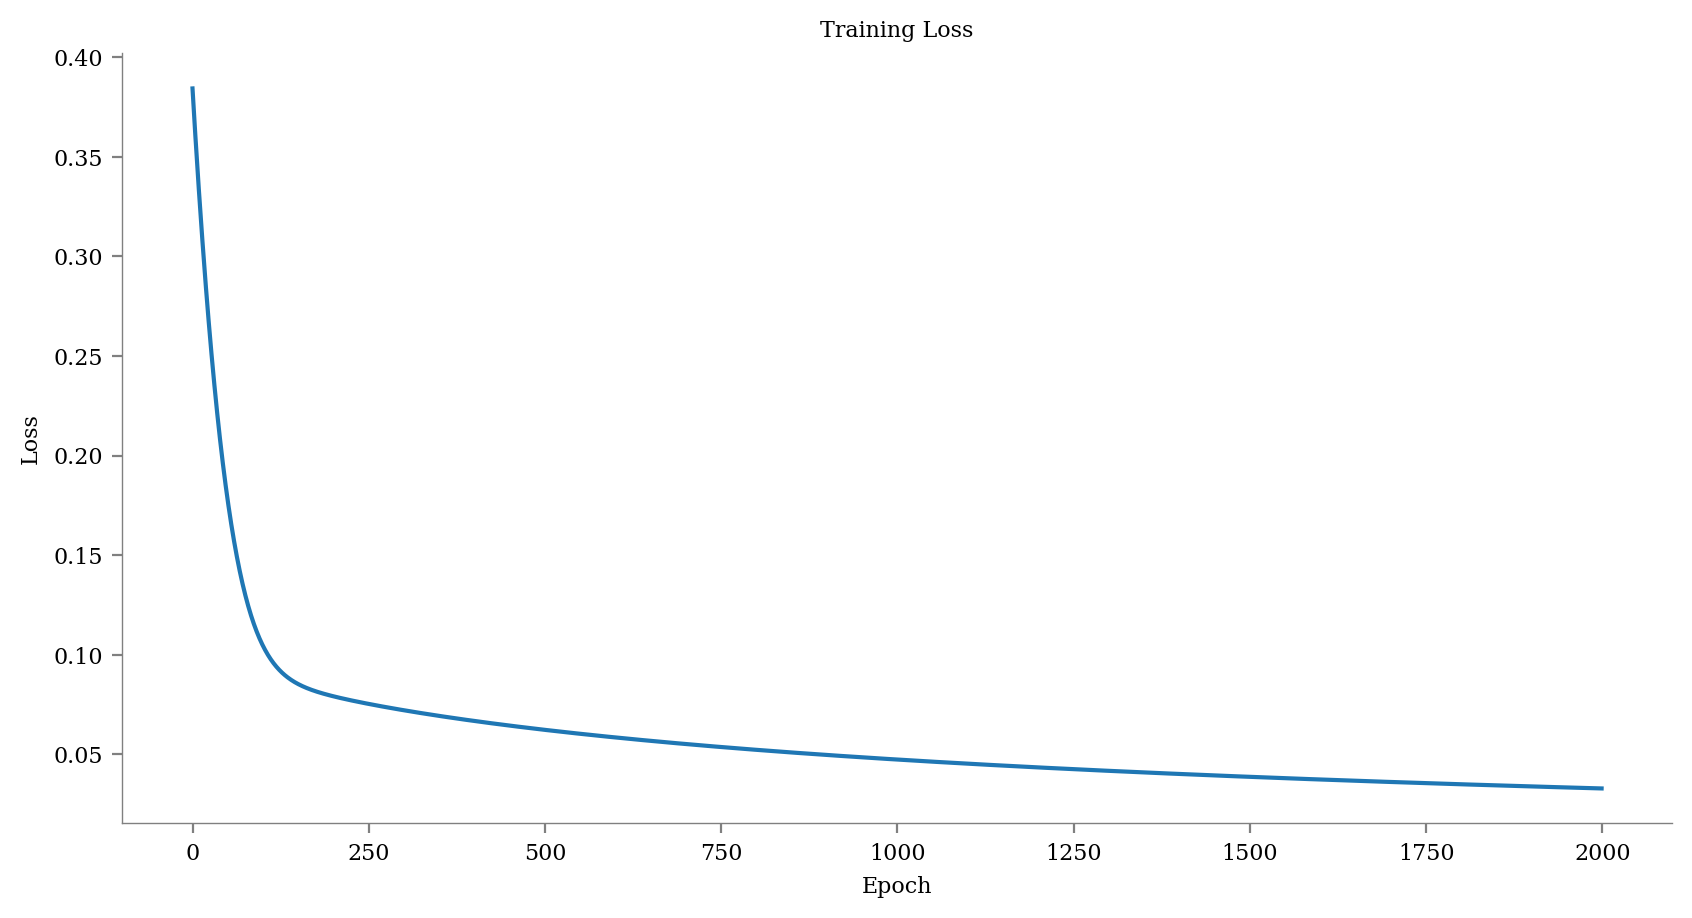

In [38]:

# plot training loss graph
plt.figure(figsize=(10, 5))
latexify()
format_axes(plt.gca())
plt.plot(training_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [39]:

model.eval()
with torch.no_grad():
    high_res_pred_Y = model(X_rff_high_res)
    high_res_pred_Y = high_res_pred_Y.reshape(400, 400, 3).cpu().numpy()
    high_res_pred_Y = np.clip(high_res_pred_Y, 0, 1)  # Clip values to [0, 1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.3074727..4.393824].


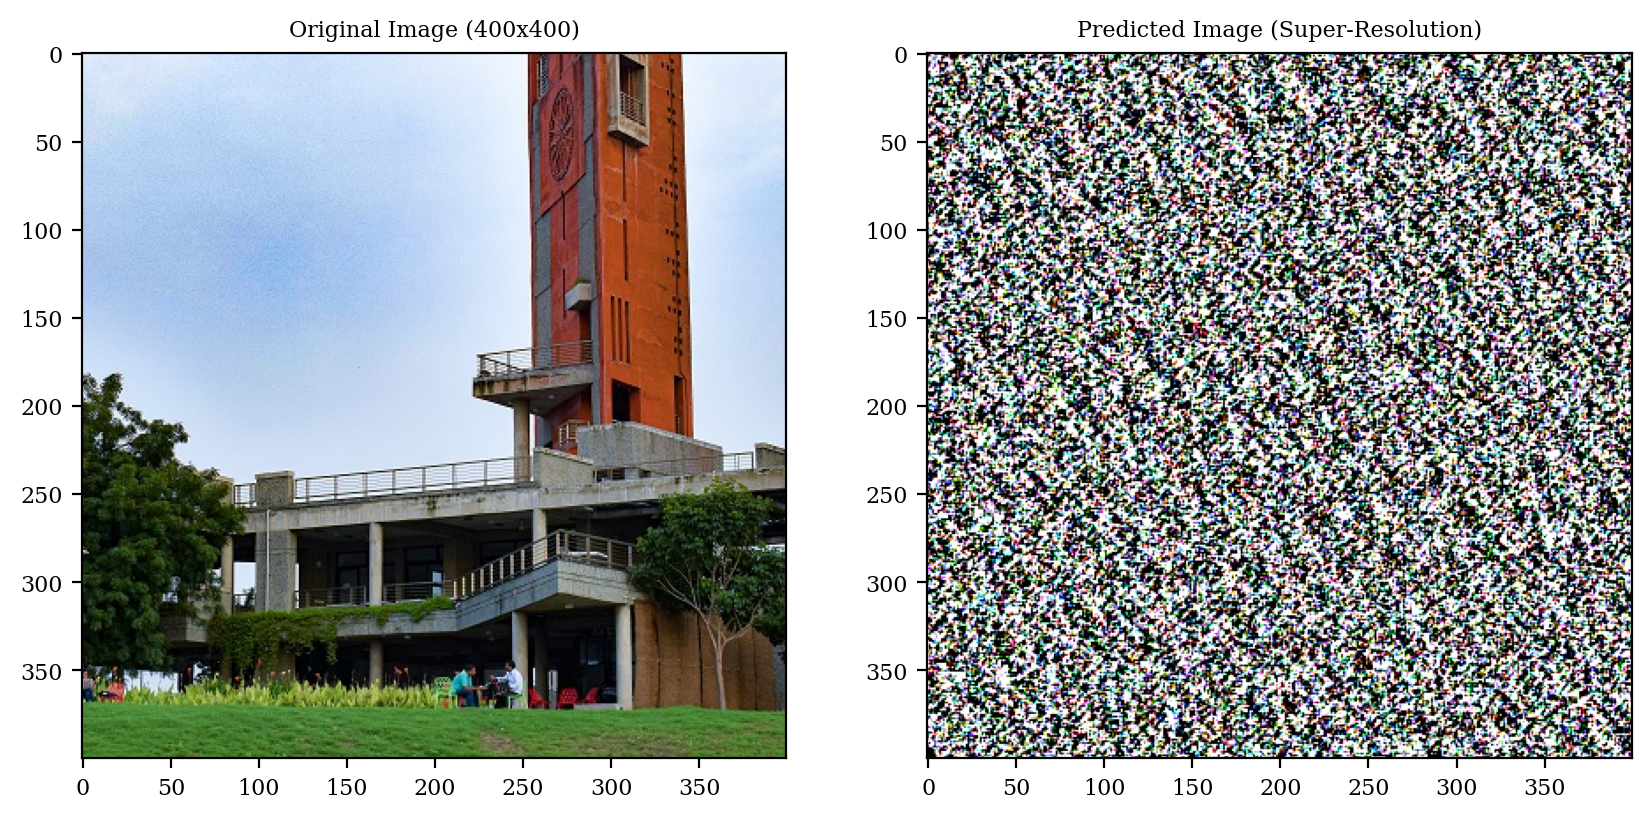

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(rearrange(original_img.cpu(), 'c h w -> h w c').numpy())
ax1.set_title('Original Image (400x400)')

ax2.imshow(high_res_pred_Y)
ax2.set_title('Predicted Image (Super-Resolution)')

plt.show()


In [41]:
from sklearn.metrics import mean_squared_error
import math

# Compute RMSE
rmse = mean_squared_error(rearrange(original_img.cpu(), 'c h w -> h w c').numpy().ravel(), high_res_pred_Y.ravel(), squared=False)

# Compute PSNR
def compute_psnr(true_img, pred_img, max_val=1.0):
    mse = mean_squared_error(true_img, pred_img)
    psnr = 20 * math.log10(max_val) - 10 * math.log10(mse)
    return psnr

psnr = compute_psnr(rearrange(original_img.cpu(), 'c h w -> h w c').numpy(), high_res_pred_Y)

print(f"RMSE: {rmse}")
print(f"PSNR: {psnr}")


ValueError: Found array with dim 3. None expected <= 2.